# Stock Price Movement Prediction Using The Deutsche Börse Public Dataset & Machine Learning - Notebook 3 (Applying A Neural Network)

Here we apply the neural network approach suggested in Notebook 1 to the data set product in Notebook 2.

## Important: 20 minute by 20 minute predictions

We adapt the approaches of notebook `03-stock-price-prediction-machine-learning.ipynb` and
notebook `supporting/simple-linear-model.ipynb` to work on 20 minutes by 20 minute basis rather than on a minute by minute.

In [1]:
import pandas as pd
import numpy as np
import glob, os
from datetime import datetime
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler
from pandas import DataFrame
from pandas import concat

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (15, 10) # use bigger graphs

from math import sqrt
from numpy import concatenate
from matplotlib import pyplot
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense, Flatten, Reshape, Conv1D, MaxPooling1D, BatchNormalization, LeakyReLU
from keras.layers import LSTM
from keras import regularizers

import datetime

Using TensorFlow backend.


We read the file we processed in the second notebook

In [2]:
input_file = '/data/processed/cooked_v3.pkl'
df = pd.read_pickle(input_file)

Checking what stocks are available in the file

In [3]:
all_mnemonics = df.Mnemonic.unique()
df.Mnemonic.unique(), df.Mnemonic.unique().shape[0]

(array(['SNH', 'DBK', 'EOAN', 'DTE', 'CBK', 'RWE', 'IFX', 'SVAB', 'LHA',
        'DAI', 'O2D', 'TKA', 'DPW', 'SIE', 'HDD', 'BAYN', 'AIXA', 'SAP',
        'BAS', 'EVT', 'AT1', 'PSM', 'BMW', 'VOW3', 'FRE', 'SDF', 'ALV',
        'CEC', 'GAZ', 'VNA', 'B4B', 'SHA', 'AB1', 'DLG', 'NDX1', 'UN01',
        'NOA3', 'IGY', 'ADS', 'VODI', '1COV', 'TUI1', 'BPE5', 'HEI', 'USE',
        'KCO', 'SZU', 'EVK', 'ADV', 'HEN3', 'MUV2', 'WDI', 'DWNI', 'MRK',
        'PAH3', 'DEZ', 'FME', 'FNTN', 'G1A', 'RKET', 'QIA', 'DB1', 'ZAL',
        'RIB', 'QSC', 'CON', 'SGL', 'BVB', 'SHL', 'PNE3', 'PBB', 'OSR',
        'TINA', 'BEI', 'TEG', 'AOX', 'UTDI', 'ARL', 'MDG1', 'SANT', 'LXS',
        'KGX', 'TTI', 'LINU', 'GYC', 'ARO', 'SOW', 'ANO', 'SZG', 'BOSS',
        'BNR', 'LLD', 'WAF', 'DRI', 'NDA', 'SY1', 'LIN', 'ZIL2', 'CAP',
        '3W9K'], dtype=object), 100)

Next we will select the most liquid stocks from this set.

In [4]:
df['Liquidity'] = df['TradedVolume']*df['EndPrice']
tmp = df.groupby('Mnemonic')['Liquidity'].sum().to_frame()
tmp['LiquidityNormalized'] = 100.0*tmp['Liquidity']/(tmp['Liquidity'].sum())
df = df.drop(columns=['Liquidity'])

tmp.sort_values('LiquidityNormalized', ascending=False).head()

,Liquidity,LiquidityNormalized
Mnemonic,,
SIE,3.743603e+10,5.516107
ALV,3.392598e+10,4.998910
BAYN,3.320337e+10,4.892436
DAI,3.313211e+10,4.881935
DBK,3.312050e+10,4.880225


In [5]:
most_liquid_stocks = list(tmp.sort_values('LiquidityNormalized', ascending=False).index[0:50])
print("50 Most liquid stocks:", ", ".join(most_liquid_stocks))

50 Most liquid stocks: SIE, ALV, BAYN, DAI, DBK, VOW3, SAP, BAS, DTE, ADS, BMW, CBK, EOAN, IFX, MUV2, RWE, LHA, DPW, CON, FRE, HEN3, TKA, 1COV, HEI, LINU, WDI, PSM, MRK, DB1, VNA, FME, LIN, PAH3, BEI, WAF, EVT, IGY, SDF, OSR, AIXA, DLG, SNH, KGX, LXS, DWNI, ZAL, BOSS, G1A, UN01, UTDI


Check what dates are available in the file. We will split the original set
into three parts, train, valid, test based on the dates.
If the dates are ordered chronologically, we take the first dates for the test set,
then we take the next dates for the validation set and finally we take what is
left for the test set

In [6]:
def date_part(dt):
    return str(dt).split(' ')[0]
unique_days = sorted(list(set(map(date_part , list(df.index.unique())))))
len(unique_days), unique_days[0:2], unique_days[-3:-1]

(217, ['2017-07-03', '2017-07-04'], ['2018-05-11', '2018-05-14'])

In [7]:
percent_train = 60.0
percent_valid = 5.0
percent_test = 100.0 - percent_train - percent_valid

offset_train = int(len(unique_days)*percent_train/100.0)
offset_test = offset_train + int(len(unique_days)*percent_valid/100.0)

train_valid_days = list(set(unique_days[0:offset_test]))

np.random.seed(484811945)
np.random.shuffle(train_valid_days)

train_days = train_valid_days[0:offset_train]
valid_days = train_valid_days[offset_train:]
test_days = set(unique_days[offset_test:])
'train', len(train_days), 'valid', len(valid_days), 'test', len(test_days)

('train', 130, 'valid', 10, 'test', 77)

In [8]:
df['CalcDateTime'] = df.index
df['Date'] = df['CalcDateTime'].dt.strftime("%Y-%m-%d")

In [9]:
df_train = df[df.Date.isin(list(train_days))]
df_valid = df[df.Date.isin(list(valid_days))]
df_test = df[df.Date.isin(list(test_days))]

We've prepared the train, test and valid sets. Make sure the days do not overlap

In [10]:
df_train[['CalcDateTime']].describe()

,CalcDateTime
count,9373000
unique,93730
top,2017-08-09 08:10:00
freq,100
first,2017-07-03 08:00:00
last,2018-01-23 20:00:00


In [11]:
df_valid[['CalcDateTime']].describe()

,CalcDateTime
count,721000
unique,7210
top,2017-09-15 14:29:00
freq,100
first,2017-08-14 08:00:00
last,2018-01-10 20:00:00


In [12]:
df_test[['CalcDateTime']].describe()

,CalcDateTime
count,5551700
unique,55517
top,2018-03-16 10:22:00
freq,100
first,2018-01-24 08:00:00
last,2018-05-15 20:00:00


In the class below we create features from the raw features

In [13]:
enable_non_linear_features = True

def closer_to_with_normalization(pnt, a, b, norm):
    """
    Returns the "directed" and normalized distance to the closer.
    @pnt: pnt which is compared to other two points, called a and b here
    @a: point a
    @b: point b
    @norm: normalization constant
    """    
    return (np.absolute(pnt - a) - np.absolute(pnt - b))/norm

def resample_single_stock(single_stock, interval):
    df = pd.DataFrame({
        'MaxPrice': single_stock['MaxPrice'].resample(interval).max(),
        'MinPrice': single_stock['MinPrice'].resample(interval).min(),
        'LastEndPrice': single_stock['EndPrice'].resample(interval).last(),
        'FirstStartPrice': single_stock['StartPrice'].resample(interval).first(),         
        'MeanEndPrice': single_stock['EndPrice'].resample(interval).mean(),        
        'HasTrade': single_stock['HasTrade'].resample(interval).max(),
        'Mnemonic': single_stock['Mnemonic'].resample(interval).last(),
        'Date': single_stock['Date'].resample(interval).last(),        
    })
    
    # Warning: this works because we had forward filled the prices
    df = df[df['HasTrade'] == 1.0]
    return df

def rev_pct_change(a, t):
    one_step_in_past = a
    t_steps_in_past = a.shift(t).ffill()
    return ((one_step_in_past - t_steps_in_past)/one_step_in_past).fillna(0.0)

def add_non_linear_features(main, resampled, interval):
    main['tmp:SignDirection@' + interval] = np.sign(main['x:Direction@' + interval])

    main['tmp:D1@' + interval] = np.where( 
        (main['tmp:SignDirection@' + interval] == 1.0) &
        (main['tmp:SignDirection@' + interval].shift(1) == 1.0), 1.0, 0.0)

    main['tmp:D2@' + interval] = np.where( 
        (main['tmp:SignDirection@' + interval] == -1.0) &
        (main['tmp:SignDirection@' + interval].shift(1) == -1.0), -1.0, 0.0)        

    main['x:D@' + interval] = main['tmp:D1@' + interval] + main['tmp:D2@' + interval]

    main['x:SignDirection-2@' + interval] = np.sign(
        (resampled['LastEndPrice'] - resampled['FirstStartPrice'].shift(2).ffill()
    )).fillna(0.0)

    main['tmp:D1@' + interval] = np.where( 
        (main['tmp:SignDirection@' + interval] == 1.0) &
        (main['tmp:SignDirection@' + interval].shift(1) == -1.0), main['x:SignDirection-2@' + interval], 0.0)

    main['tmp:D2@' + interval] = np.where( 
        (main['tmp:SignDirection@' + interval] == -1.0) &
        (main['tmp:SignDirection@' + interval].shift(1) == 1.0), main['x:SignDirection-2@' + interval], 0.0)        

    main['x:Da@' + interval] = main['tmp:D1@' + interval] + main['tmp:D2@' + interval]
    
    main = main.drop(columns=[
        'tmp:SignDirection@' + interval,
        'tmp:D1@' + interval,
        'tmp:D2@' + interval
    ])
        
    return main

def prepare_single_stock_multi_intervals(single_stock, predicted_price, main_interval, intervals):
        
    main = resample_single_stock(single_stock, main_interval)
    # we use the same anchor
    anchor = main['MeanEndPrice']
    future_mean_price = main[predicted_price].shift(-1)
    
    main['y(Return)'] = (future_mean_price - anchor)/anchor

    # do not normalize
    main['pseudo_y(SignReturn)'] = np.sign(main['y(Return)'])

    # actual return won't be normalized
    main['pseudo_y(pctChange)'] = (future_mean_price - anchor)/anchor
    
    # baseline will be normalized
    main['baseline'] = main['pseudo_y(pctChange)'].shift(1).fillna(0.0)    
    
    all_intervals = [main_interval] + intervals
    
    for interval in all_intervals:
        sub = resample_single_stock(single_stock, interval)
        resampled = sub.resample(main_interval).last() 

        main['x:Direction@' + interval] = \
            2.0*(resampled['LastEndPrice'] - resampled['FirstStartPrice'])/ \
            anchor

        if enable_non_linear_features:
            main = add_non_linear_features(main, resampled, interval)

        main['x:H1@' + interval] = - closer_to_with_normalization(
                                                 resampled['LastEndPrice'], 
                                                 resampled['MaxPrice'], 
                                                 resampled['MinPrice'],
                                                 anchor)    
        
        main['x:EndToMean@' + interval] = (resampled['LastEndPrice'] - resampled['MeanEndPrice'])/anchor
        
        main['x:AdjustedPctChange@' + interval] = (resampled['LastEndPrice'] - resampled['MeanEndPrice'])/resampled['MeanEndPrice']
        main['x:RevPctChange@' + interval] = rev_pct_change(resampled['LastEndPrice'], 1)
    
    main = main[main['HasTrade'] == 1.0]
    meta = main[['MeanEndPrice', 'HasTrade', 'LastEndPrice']]
    main = main.drop(columns = [
        'MaxPrice',
        'MinPrice',
        'LastEndPrice',
        'FirstStartPrice',         
        'MeanEndPrice',     
        'HasTrade'       
    ])
    return main, meta

In [14]:
class NARemover:
    def __init__(self, name):
        self.name = name
    def transform(self, single_stock):
        before = single_stock.shape[0]
        single_stock = single_stock.dropna()
        after = single_stock.shape[0]
        print("{}: Dropped {:2.2f} % of records due to NA".format(self.name, 100.0*(before - after)/(0.0001 + before)))
        return single_stock

The variable we use for predictions start with `x(`, while the variables that should be predicted start with `y(`

In [15]:
dummy = df_train[df_train.Mnemonic == 'BMW'].copy()
dummy = dummy[dummy.HasTrade == 1.0]
#main_interval_dummy, intervals_dummy = '20Min', ['5Min', '10Min', '15Min']
main_interval_dummy, intervals_dummy = '20Min', ['5Min', '10Min']

dummy, meta = prepare_single_stock_multi_intervals(dummy, 'MeanEndPrice', main_interval_dummy, intervals_dummy)
dummy.head()

,Mnemonic,Date,y(Return),pseudo_y(SignReturn),pseudo_y(pctChange),baseline,x:Direction@20Min,x:D@20Min,x:SignDirection-2@20Min,x:Da@20Min,...,x:AdjustedPctChange@5Min,x:RevPctChange@5Min,x:Direction@10Min,x:D@10Min,x:SignDirection-2@10Min,x:Da@10Min,x:H1@10Min,x:EndToMean@10Min,x:AdjustedPctChange@10Min,x:RevPctChange@10Min
CalcDateTime,,,,,,,,,,,,,,,,,,,,,
2017-07-03 08:00:00,BMW,2017-07-03,0.002151,1.0,0.002151,0.000000,0.000488,0.0,0.0,0.0,...,0.000000,0.000000,0.000488,0.0,0.0,0.0,0.000976,0.000439,0.000439,0.000000
2017-07-03 08:20:00,BMW,2017-07-03,0.001739,1.0,0.001739,0.002151,0.005845,1.0,0.0,0.0,...,-0.000146,0.002919,0.002436,1.0,0.0,0.0,0.001096,0.000379,0.000379,0.002919
2017-07-03 08:40:00,BMW,2017-07-03,-0.000097,-1.0,-0.000097,0.001739,0.002918,1.0,1.0,0.0,...,0.000170,0.001336,0.002675,1.0,1.0,0.0,0.001216,0.000413,0.000413,0.001336
2017-07-03 09:00:00,BMW,2017-07-03,-0.000109,-1.0,-0.000109,-0.000097,-0.002918,0.0,1.0,1.0,...,0.000438,-0.001582,-0.002918,0.0,1.0,1.0,-0.000486,-0.000012,-0.000012,-0.001582
2017-07-03 09:20:00,BMW,2017-07-03,0.000863,1.0,0.000863,-0.000109,0.001702,0.0,1.0,1.0,...,-0.000073,0.000851,0.001702,0.0,1.0,1.0,0.000608,-0.000036,-0.000036,0.000851


In [16]:
class TrainingSet:
    def __init__(self, X, y, orig_df):
        self.X = X
        self.y = y
        self.baseline = orig_df['baseline'].values
        self.original_df = orig_df
        
class TrainingSetBuilder:
    def transform(self, single_stock):
        x_features = filter(lambda name: name.startswith('x(') or name.startswith('x:'), list(single_stock.dtypes.index))
        X = single_stock[x_features].values
        y = single_stock[['pseudo_y(SignReturn)']].values 
        return TrainingSet(X, y, single_stock)

In [17]:
class Predictions:
    def __init__(self, predictions, training_set):

        self.predictions = predictions
        self.training_set = training_set
        
    def evaluate(self):
        single_feature = 'baseline'
        stats_df = pd.DataFrame({
                      'predictions': self.predictions[:,0],
                      'single_feature_pred': self.training_set.original_df[single_feature].values,
                      'pseudo_y(SignReturn)': self.training_set.y[:,0],
                      'pseudo_y(pctChange)': self.training_set.original_df['pseudo_y(pctChange)'].values,
                      'y(Return)': self.training_set.original_df['y(Return)'].values})
        
        corr = stats_df. \
            corr()[['predictions', 'single_feature_pred']]. \
            iloc[1:]
            
        pred_signs = np.sign(stats_df['predictions'])
        y_signs = np.sign(stats_df['y(Return)'])
        has_answer = np.absolute(pred_signs * y_signs).sum()
        correct = np.where(pred_signs * y_signs == 1.0, 1.0, 0.0).sum()
        
        thresholds = []
        accuracy = []
        correct_lst = []
        errors = []
        percent_has_answer = []
        abs_has_answer = []
        achieved_returns = []

        preds = stats_df['predictions']
        
        for d in range(5, 46, 5):
            low = np.percentile(preds, d) 
            high = np.percentile(preds, 100 - d)
            thresholded = np.where(preds > high, 1.0, np.where(preds < low, -1.0, 0.0))
            c = np.where(np.sign(thresholded)*np.sign(y_signs) == 1.0, 1.0, 0.0).sum()
            e = np.where(np.sign(thresholded)*np.sign(y_signs) == -1.0, 1.0, 0.0).sum()
            achieved_ret = (stats_df['pseudo_y(pctChange)']*thresholded).sum()
            correct_lst.append(c)
            errors.append(e)
            accuracy.append(c/(c + e))
            percent_has_answer.append(100.0*(c + e)/pred_signs.shape[0])
            abs_has_answer.append((c + e))
            achieved_returns.append(achieved_ret)
            thresholds.append(d)
            
        at_cutoff = DataFrame({
                    'thresholds': thresholds,
                    'accuracy': accuracy,
                    'percent_with_answer': percent_has_answer,
                    'absolute_has_answer': abs_has_answer,
                    'achieved_returns': achieved_returns,
                    'correct': correct_lst,
                    'errors': errors
        })
        at_cutoff['achieved_norm_returns'] = at_cutoff['achieved_returns']/at_cutoff['absolute_has_answer']
        
        ret = stats_df['pseudo_y(pctChange)']
        rand_feature = np.where(np.random.rand(ret.shape[0]) > 0.5, 1.0, -1.0)    
        random_returns = (ret * rand_feature).sum()
        always_up_returns = (ret*1.0).sum()
        always_down_returns = (ret*-1.0).sum()
        omnicient_returns = (np.absolute(ret)).sum()
        achieved = (ret * pred_signs).sum()
        return {
            'corr': corr,
            'accuracy_at_cutoff': at_cutoff,
            'matches': {
                'percent_correct': 100*correct/has_answer,
                'percent_has_answer': has_answer/pred_signs.shape[0],
                'absolute_with_answer': has_answer,
                'size': pred_signs.shape[0]
            },
            'strategies': {
                'omniscient': omnicient_returns,
                'random': random_returns,
                'always_up': always_up_returns,
                'always_down': always_down_returns,
                'achieved': achieved,
                'num_trials': np.absolute(pred_signs).sum()
            }
        }
    
class MLModel:
    def __init__(self):
        self.model = None
        
    def fit(self, training_set, valid_set = None):
        train_X, train_y = training_set.X, training_set.y
        
        if valid_set is None:
            valid_X, valid_y = train_X, train_y
        else:
            valid_X, valid_y = valid_set.X, valid_set.y

        model = Sequential()

        model.add(Dense(10, activation='relu', input_shape =(train_X.shape[1],),
                        kernel_regularizer=regularizers.l2(0.1))) 
        model.add(Dense(5, activation='relu', kernel_regularizer=regularizers.l2(0.1)))        

        model.add(Dense(1))
        
        model.compile(loss='mean_squared_error', optimizer='adam')
        self.model = model            

        # fit network
        history = model.fit(train_X, train_y, epochs=150, batch_size=2500, validation_data=(valid_X, valid_y), verbose=2, shuffle=True)
        # plot history
        pyplot.plot(history.history['loss'], label='train')
        pyplot.plot(history.history['val_loss'], label='valid')
        pyplot.legend()
        pyplot.show()
        
    def transform(self, input_set):
        predictions = self.model.predict(input_set.X)
        return Predictions(predictions, input_set)
    
    def fit_transform(self, training_set, valid_set):
        self.fit(training_set, valid_set)
        return self.transform(training_set), self.transform(valid_set)

In [18]:
def make_inverter(m, s, th):
    return lambda y: y*s + m

def make_transformer(m, s, th):
    def transform(fn):
        norm = (fn-m)/s
        return np.where(norm > th, th, np.where(norm < -th, -th, norm))
    return transform

def fit_normalize_features(prepared_single_stock):
    th = 2.5  
    inp = prepared_single_stock.copy()
    inverters = {}
    transformers = {}
    
    for f in list(inp.dtypes.index):
        if f.startswith('x(') or f.startswith('x:') or f == 'baseline':
            fn = inp[f]
            s = 0.0000001 + np.std(fn.values)
            m = np.mean(fn.values)

            inverters[f] = make_inverter(m, s, th)
            transformers[f] = make_transformer(m, s, th)
            inp[f] = transformers[f](fn)
        
    return inp, transformers, inverters

def normalize_features(prepared_single_stock, transformers):
    inp = prepared_single_stock.copy()    
    for f in list(inp.dtypes.index):
        if f.startswith('x(') or f.startswith('x:') or f == 'baseline':
            fn = inp[f]
            inp[f] = transformers[f](fn)
    return inp

In [19]:
combined_training_set = []
combined_valid_set = []
combined_test_set = []

#main_interval, intervals = '20Min', ['5Min', '10Min', '15Min']
main_interval, intervals = '20Min', ['5Min', '10Min']
#main_interval, intervals = '4H', ['30Min', '1H', '2H']

normalizers = {}

for mnemonic in most_liquid_stocks:
    single_stock = df_train[df_train.Mnemonic == mnemonic].copy()
    single_stock = single_stock[single_stock.HasTrade == 1.0]
    single_stock, meta = prepare_single_stock_multi_intervals(single_stock, 'MeanEndPrice', main_interval, intervals)
    single_stock = NARemover(mnemonic).transform(single_stock)
    single_stock, single_stock_transformer, _ = fit_normalize_features(single_stock)
    normalizers[mnemonic] = single_stock_transformer
    
    combined_training_set.append(single_stock)
    print("train", single_stock.shape)
    
    single_stock = df_valid[df_valid.Mnemonic == mnemonic].copy()
    single_stock = single_stock[single_stock.HasTrade == 1.0] 
    single_stock, meta = prepare_single_stock_multi_intervals(single_stock, 'MeanEndPrice', main_interval, intervals)
    single_stock = NARemover(mnemonic).transform(single_stock)
    single_stock = normalize_features(single_stock, normalizers[mnemonic])
    
    combined_valid_set.append(single_stock)
    print("valid", single_stock.shape)    
    
    single_stock = df_test[df_test.Mnemonic == mnemonic].copy()
    single_stock = single_stock[single_stock.HasTrade == 1.0] 
    single_stock, meta = prepare_single_stock_multi_intervals(single_stock, 'MeanEndPrice', main_interval, intervals)
    single_stock = NARemover(mnemonic).transform(single_stock)
    single_stock = normalize_features(single_stock, normalizers[mnemonic])
    combined_test_set.append(single_stock)
    print("test", single_stock.shape) 
    
combined_training_set_df = pd.concat(combined_training_set, axis=0)
training_set = TrainingSetBuilder().transform(combined_training_set_df)
    
combined_valid_set_df = pd.concat(combined_valid_set, axis=0)
valid_set = TrainingSetBuilder().transform(combined_valid_set_df) 

combined_test_set_df = pd.concat(combined_test_set, axis=0)
test_set = TrainingSetBuilder().transform(combined_test_set_df) 
    
print(training_set.original_df.shape, valid_set.original_df.shape,  test_set.original_df.shape)

SIE: Dropped 0.03 % of records due to NA
train (3088, 30)
SIE: Dropped 0.40 % of records due to NA
valid (250, 30)
SIE: Dropped 0.05 % of records due to NA
test (1888, 30)
ALV: Dropped 0.03 % of records due to NA
train (3089, 30)
ALV: Dropped 0.40 % of records due to NA
valid (250, 30)
ALV: Dropped 0.05 % of records due to NA
test (1888, 30)
BAYN: Dropped 0.03 % of records due to NA
train (3088, 30)
BAYN: Dropped 0.40 % of records due to NA
valid (250, 30)
BAYN: Dropped 0.05 % of records due to NA
test (1888, 30)
DAI: Dropped 0.03 % of records due to NA
train (3089, 30)
DAI: Dropped 0.40 % of records due to NA
valid (250, 30)
DAI: Dropped 0.05 % of records due to NA
test (1888, 30)
DBK: Dropped 0.03 % of records due to NA
train (3088, 30)
DBK: Dropped 0.40 % of records due to NA
valid (250, 30)
DBK: Dropped 0.05 % of records due to NA
test (1888, 30)
VOW3: Dropped 0.03 % of records due to NA
train (3088, 30)
VOW3: Dropped 0.40 % of records due to NA
valid (250, 30)
VOW3: Dropped 0.05 %

G1A: Dropped 0.05 % of records due to NA
test (1888, 30)
UN01: Dropped 0.03 % of records due to NA
train (3089, 30)
UN01: Dropped 0.40 % of records due to NA
valid (250, 30)
UN01: Dropped 0.05 % of records due to NA
test (1888, 30)
UTDI: Dropped 0.03 % of records due to NA
train (3086, 30)
UTDI: Dropped 0.40 % of records due to NA
valid (250, 30)
UTDI: Dropped 0.05 % of records due to NA
test (1888, 30)
(152967, 30) (12433, 30) (94392, 30)


In [20]:
from sklearn.linear_model import Ridge
class LinearModel:
    def __init__(self):
        self.model = None
        
    def fit(self, training_set, valid_set = None):
        train_X, train_y = training_set.X[:,:], training_set.y
        
        if valid_set is None:
            valid_X, valid_y = train_X, train_y
        else:
            valid_X, valid_y = valid_set.X, valid_set.y
            
        self.model = Ridge(alpha=1.5)
        # train_y should be -1/+1
        self.model.fit(train_X, train_y)
       

    def transform(self, input_set):
        return Predictions(self.model.predict(input_set.X), input_set)
    
    def fit_transform(self, training_set, valid_set):
        self.fit(training_set, valid_set)
        return self.transform(training_set), self.transform(valid_set)    

model = LinearModel()
train_predictions, valid_predictions = model.fit_transform(training_set, valid_set)
print("Fitted model")

Fitted model


In [21]:
train_predictions.evaluate()['matches']

{'percent_correct': 71.44165478262008,
 'percent_has_answer': 0.999339726869194,
 'absolute_with_answer': 152866.0,
 'size': 152967}

In [22]:
valid_predictions.evaluate()['matches']

{'percent_correct': 71.85513078470825,
 'percent_has_answer': 0.9993565511139709,
 'absolute_with_answer': 12425.0,
 'size': 12433}

In [23]:
test_predictions = model.transform(test_set)
test_predictions.evaluate()['matches']

{'percent_correct': 71.42857142857143,
 'percent_has_answer': 0.9992901940842445,
 'absolute_with_answer': 94325.0,
 'size': 94392}

In [24]:
train_predictions.evaluate()['accuracy_at_cutoff']

,thresholds,accuracy,percent_with_answer,absolute_has_answer,achieved_returns,correct,errors,achieved_norm_returns
0,5,0.919456,9.999542,15296.0,43.929000,14064.0,1232.0,0.002872
1,10,0.892049,19.996470,30588.0,67.264799,27286.0,3302.0,0.002199
2,15,0.868518,29.991436,45877.0,84.475350,39845.0,6032.0,0.001841
3,20,0.844188,39.989017,61170.0,97.846112,51639.0,9531.0,0.001600
4,25,0.821615,49.987252,76464.0,108.669062,62824.0,13640.0,0.001421
5,30,0.799185,59.977642,91746.0,116.867187,73322.0,18424.0,0.001274
6,35,0.776832,69.967379,107027.0,122.666545,83142.0,23885.0,0.001146
7,40,0.755782,79.962999,122317.0,126.745088,92445.0,29872.0,0.001036
8,45,0.735089,89.954696,137601.0,128.973332,101149.0,36452.0,0.000937


In [25]:
def pred_baseline(d):
    single_feature = 'baseline'
    preds = d.training_set.original_df[single_feature].values
    preds = preds.reshape((preds.shape[0], 1))
    return Predictions(preds, d.training_set).evaluate()

def readable_summary(which_set, p):
    achieved = p.evaluate()['strategies']['achieved']
    achieved_baseline = pred_baseline(p)['strategies']['achieved']
    per_change = np.mean(np.absolute(p.training_set.original_df['pseudo_y(pctChange)']))
    n = p.training_set.original_df.shape[0]
    print ("""Conclusion:

If you play {} times on the {} with 1 EUR and you always guess the movement,
ignoring all transactions cost (which would likely be significant), you will make {}. 

Instead you make {} or {} percent of the ideally achievable.

If you use the baseline you will make {} or {} percent of ideal.

Disclaimer:

It is important to note that the purpose of this evaluation is to make
an interpretation of prediction accuracy in the context of financial gains.
However, the current evaluation does not mean that such gains are practically
achievable. For example, slippage is not taken into account.


For proper evaluation one should run backtests. 
It's important to know that a preditive model in itself is insufficient
as there are other components.


Those experiments are not a financial advise.

""".format(
        n, which_set, n * per_change, achieved, 100.0*achieved/(n*per_change),
          achieved_baseline, 100.0*achieved_baseline/(n*per_change)))
readable_summary('Training Set', train_predictions)

Conclusion:

If you play 152967 times on the Training Set with 1 EUR and you always guess the movement,
ignoring all transactions cost (which would likely be significant), you will make 243.48361373226663. 

Instead you make 130.64905697726385 or 53.658254440450726 percent of the ideally achievable.

If you use the baseline you will make 47.11323501206654 or 19.349653264088655 percent of ideal.

Disclaimer:

It is important to note that the purpose of this evaluation is to make
an interpretation of prediction accuracy in the context of financial gains.
However, the current evaluation does not mean that such gains are practically
achievable. For example, slippage is not taken into account.


For proper evaluation one should run backtests. 
It's important to know that a preditive model in itself is insufficient
as there are other components.


Those experiments are not a financial advise.




In [26]:
train_predictions.evaluate()['strategies']

{'omniscient': 243.48361373226663,
 'random': 1.4376786194139808,
 'always_up': 6.152936104145533,
 'always_down': -6.152936104145533,
 'achieved': 130.64905697726385,
 'num_trials': 152967.0}

In [27]:
pred_baseline(valid_predictions)['strategies'] 

{'omniscient': 35.15962063916294,
 'random': 1.272734284669614,
 'always_up': 5.065717134003669,
 'always_down': -5.065717134003669,
 'achieved': 2.5580695863993164,
 'num_trials': 12433.0}

In [28]:
valid_predictions.evaluate()['accuracy_at_cutoff']

,thresholds,accuracy,percent_with_answer,absolute_has_answer,achieved_returns,correct,errors,achieved_norm_returns
0,5,0.925241,10.005630,1244.0,3.284452,1151.0,93.0,0.002640
1,10,0.893044,20.003217,2487.0,4.498675,2221.0,266.0,0.001809
2,15,0.864270,29.984718,3728.0,5.780089,3222.0,506.0,0.001550
3,20,0.846138,39.990348,4972.0,7.019511,4207.0,765.0,0.001412
4,25,0.826493,49.971849,6213.0,7.832817,5135.0,1078.0,0.001261
5,30,0.799920,59.977479,7457.0,8.379726,5965.0,1492.0,0.001124
6,35,0.779795,69.983109,8701.0,9.687775,6785.0,1916.0,0.001113
7,40,0.759807,79.964610,9942.0,11.554939,7554.0,2388.0,0.001162
8,45,0.738174,89.946111,11183.0,9.812031,8255.0,2928.0,0.000877


### Baseline on Testset: Accuracy at different levels

In [29]:
# this is for the baseline
pred_baseline(test_predictions)['accuracy_at_cutoff'] 

,thresholds,accuracy,percent_with_answer,absolute_has_answer,achieved_returns,correct,errors,achieved_norm_returns
0,5,0.625358,9.993432,9433.0,8.836721,5899.0,3534.0,0.000937
1,10,0.627590,19.990042,18869.0,16.219807,11842.0,7027.0,0.000860
2,15,0.619695,29.982414,28301.0,22.040602,17538.0,10763.0,0.000779
3,20,0.610144,39.979024,37737.0,26.470858,23025.0,14712.0,0.000701
4,25,0.602752,49.969277,47167.0,29.995626,28430.0,18737.0,0.000636
5,30,0.595166,59.963768,56601.0,33.018019,33687.0,22914.0,0.000583
6,35,0.587767,69.956140,66033.0,34.956086,38812.0,27221.0,0.000529
7,40,0.579888,79.951691,75468.0,36.904705,43763.0,31705.0,0.000489
8,45,0.573401,89.940885,84897.0,38.010867,48680.0,36217.0,0.000448


### Baseline on Testset: Comparison of Returns

In [30]:
# this is for the baseline
pred_baseline(test_predictions)['strategies']

{'omniscient': 185.98927815669765,
 'random': 1.135187076096661,
 'always_up': -3.7637348158124975,
 'always_down': 3.7637348158124975,
 'achieved': 38.16610494514903,
 'num_trials': 94392.0}

### ML Model on Testset: Accuracy at different levels

In [31]:
# this is for ML
test_predictions.evaluate()['accuracy_at_cutoff']

,thresholds,accuracy,percent_with_answer,absolute_has_answer,achieved_returns,correct,errors,achieved_norm_returns
0,5,0.918512,9.997669,9437.0,31.231169,8668.0,769.0,0.003309
1,10,0.888477,19.996398,18875.0,49.435511,16770.0,2105.0,0.002619
2,15,0.865838,29.990889,28309.0,63.853908,24511.0,3798.0,0.002256
3,20,0.844784,39.983261,37741.0,75.597596,31883.0,5858.0,0.002003
4,25,0.822258,49.977752,47175.0,84.607390,38790.0,8385.0,0.001793
5,30,0.801152,59.969065,56606.0,91.535937,45350.0,11256.0,0.001617
6,35,0.779386,69.957200,66034.0,96.754410,51466.0,14568.0,0.001465
7,40,0.757497,79.950631,75467.0,99.725626,57166.0,18301.0,0.001321
8,45,0.736080,89.940885,84897.0,102.186883,62491.0,22406.0,0.001204


### ML Model on Testset: Comparison of Returns

In [32]:
# for ML
Predictions(test_predictions.predictions, test_predictions.training_set).evaluate()['strategies']

{'omniscient': 185.98927815669765,
 'random': -0.28116685056831764,
 'always_up': -3.7637348158124975,
 'always_down': 3.7637348158124975,
 'achieved': 102.59568176937755,
 'num_trials': 94392.0}

In [33]:
readable_summary('Test set', test_predictions)

Conclusion:

If you play 94392 times on the Test set with 1 EUR and you always guess the movement,
ignoring all transactions cost (which would likely be significant), you will make 185.98927815669768. 

Instead you make 102.59568176937755 or 55.162148477687914 percent of the ideally achievable.

If you use the baseline you will make 38.16610494514903 or 20.520594156504945 percent of ideal.

Disclaimer:

It is important to note that the purpose of this evaluation is to make
an interpretation of prediction accuracy in the context of financial gains.
However, the current evaluation does not mean that such gains are practically
achievable. For example, slippage is not taken into account.


For proper evaluation one should run backtests. 
It's important to know that a preditive model in itself is insufficient
as there are other components.


Those experiments are not a financial advise.




### Analysis by Mnemonic and by Date

It is known that when it comes to stock predictions, different stocks and different days will exibit different performance

In [34]:
def plot_accuracy_by(grouping_feature, predictions):
    df = predictions.training_set.original_df
    s = df[['Date', 'Mnemonic', 'pseudo_y(SignReturn)']].copy()
    s['Predictions'] = predictions.predictions
    s['Baseline'] = df['baseline']

    def agg(group):
        pred = group['Predictions']
        baseline = group['Baseline']
        rets = group['pseudo_y(SignReturn)']
        c = pred.corr(rets)
        c = np.where(np.sign(pred)*np.sign(rets) == 1.0, 1.0, 0.0).sum()
        e = np.where(np.sign(pred)*np.sign(rets) == -1.0, 1.0, 0.0).sum()
        acc = c/(c + e)

        c_baseline = np.where(np.sign(baseline)*np.sign(rets) == 1.0, 1.0, 0.0).sum()
        e_baseline = np.where(np.sign(baseline)*np.sign(rets) == -1.0, 1.0, 0.0).sum()
        acc_baseline = c_baseline/(c_baseline + e_baseline)

        l = group.shape[0]
        return {"corr": c, 'size': l, 'accuracy': acc, 'acc_baseline': acc_baseline}
    f = s.groupby(grouping_feature).apply(agg).to_frame("agg")

    f['AccuracyPred'] = f['agg'].map(lambda i: i['accuracy'])
    f['AccuracyBaseline'] = f['agg'].map(lambda i: i['acc_baseline'])
    f['AccPred - AccBaseline'] = f['AccuracyPred'] - f['AccuracyBaseline']
    f = f.drop(columns=['agg'])

    f = f[f.index != '2017-10-14'] # remove this date which has one data point
    f[['AccuracyPred', 'AccuracyBaseline']].plot()
    return f

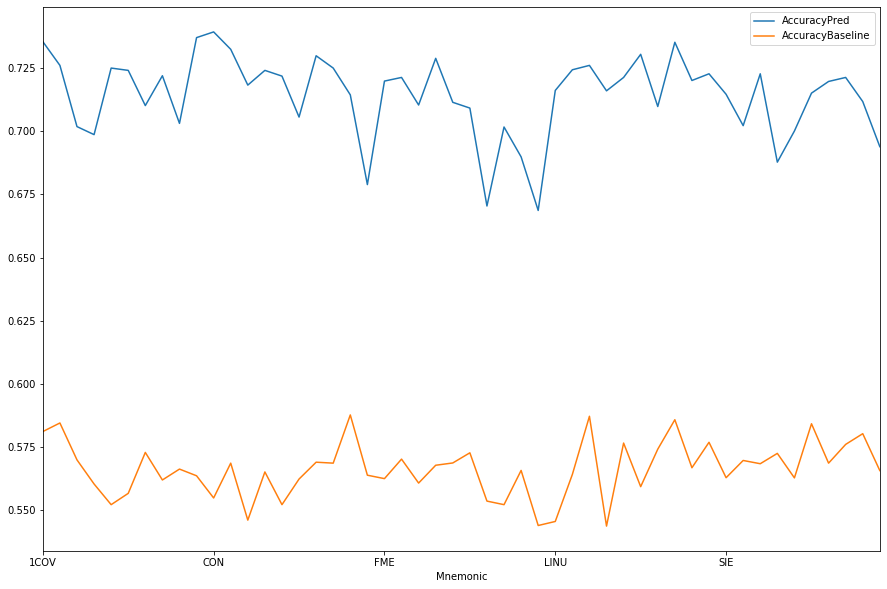

In [35]:
perf = plot_accuracy_by('Mnemonic', test_predictions)

In [36]:
perf.sort_values(by='AccuracyPred', ascending=False).head(20)

,AccuracyPred,AccuracyBaseline,AccPred - AccBaseline
Mnemonic,,,
CON,0.739269,0.554849,0.184420
CBK,0.737010,0.563627,0.173383
1COV,0.735419,0.581124,0.154295
RWE,0.735169,0.585805,0.149364
DAI,0.732379,0.568627,0.163752
PAH3,0.730403,0.559322,0.171081
DTE,0.729830,0.569002,0.160828
HEI,0.728814,0.567797,0.161017
ADS,0.726020,0.584526,0.141494


In [37]:
perf.sort_values(by='AccuracyPred', ascending=False).tail(20)

,AccuracyPred,AccuracyBaseline,AccPred - AccBaseline
Mnemonic,,,
EOAN,0.714361,0.587705,0.126656
WDI,0.711712,0.580286,0.131426
HEN3,0.711406,0.568700,0.142706
G1A,0.710345,0.560743,0.149602
BEI,0.710122,0.572867,0.137255
PSM,0.709746,0.574153,0.135593
IFX,0.709130,0.572718,0.136412
DPW,0.705570,0.562334,0.143236
BOSS,0.703075,0.566278,0.136797


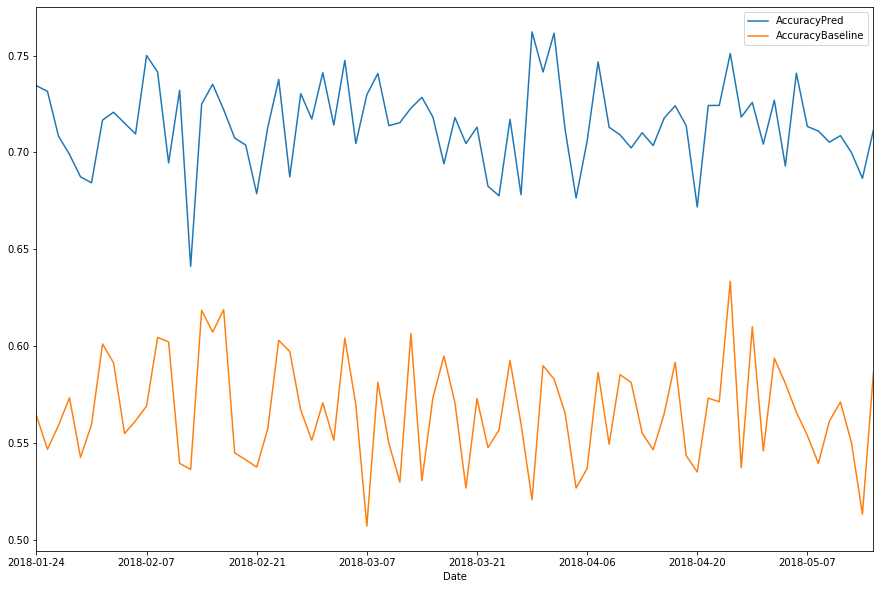

In [38]:
perf = plot_accuracy_by('Date', test_predictions)

In [39]:
perf.sort_values(by='AccuracyPred', ascending=False).head(20)

,AccuracyPred,AccuracyBaseline,AccPred - AccBaseline
Date,,,
2018-03-28,0.762195,0.520906,0.241289
2018-04-03,0.761532,0.583116,0.178416
2018-04-25,0.751088,0.633594,0.117493
2018-02-07,0.750000,0.569231,0.180769
2018-03-05,0.747498,0.604311,0.143187
2018-04-09,0.746736,0.586597,0.160139
2018-02-08,0.741538,0.604615,0.136923
2018-03-29,0.741514,0.590078,0.151436
2018-03-01,0.741140,0.570878,0.170262


In [40]:
perf.sort_values(by='AccuracyPred', ascending=False).tail(20)

,AccuracyPred,AccuracyBaseline,AccPred - AccBaseline
Date,,,
2018-04-30,0.704348,0.546087,0.158261
2018-02-20,0.703846,0.541538,0.162308
2018-04-16,0.703575,0.546643,0.156931
2018-04-12,0.702350,0.581375,0.120975
2018-05-11,0.700000,0.550435,0.149565
2018-01-29,0.698999,0.573518,0.125481
2018-02-09,0.694615,0.602308,0.092308
2018-03-16,0.694167,0.595000,0.099167
2018-05-03,0.693043,0.580870,0.112174


In [41]:
!echo "Last run on `date`"

Last run on Wed Jan 22 18:38:49 UTC 2020
